# 따릉이 대여량 예측 공유

처음으로 도전해본 경진대회에서, Public 결과와는 다르게 전혀 생각지도 않았던 Private 1등을 하게 되어.. 제가 생각했던 흐름과 코드를 공유하고자 합니다. 아직 많이 부족하지만, 좋은 피드백 주시면 감사드리겠습니다.!

기존에 올라와있던 EDA 자료와, 코드 공유에 있던 많은 부분 또한 적용해보았고, 또 직접 새로 생각한 부분들도 있습니다..!
기술적인 부분은 어렵지 않으나 변수의 의미에 조금 더 초점을 두고 이야기를 풀어나가볼까 싶습니다.

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
from xgboost import XGBRegressor, plot_tree, plot_importance

from sklearn.model_selection import GridSearchCV

import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
train_df = pd.read_csv('C:/Users/USER/Desktop/Data_Projects/DaconBasic_bicycle_rental/train.csv')
test_df = pd.read_csv('C:/Users/USER/Desktop/Data_Projects/DaconBasic_bicycle_rental/test.csv')
sample_submission = pd.read_csv('C:/Users/USER/Desktop/Data_Projects/DaconBasic_bicycle_rental/sample_submission.csv')

## Section 1. EDA

In [3]:
train_df

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833
...,...,...,...,...,...,...,...,...,...,...
268,2020-06-26,228.662,3.980,0.223,2.271,78.378,20.500,27.526,36.486,96150
269,2020-06-27,207.770,2.865,0.081,1.794,78.412,20.812,28.842,21.081,107001
270,2020-06-28,282.568,1.730,0.000,1.820,72.736,21.000,29.053,7.297,98568
271,2020-06-29,137.027,2.257,0.088,2.043,70.473,19.625,26.000,15.541,70053


In [4]:
test_df

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability
0,2021-04-01,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333
1,2021-04-02,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500
2,2021-04-03,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847
3,2021-04-04,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671
4,2021-04-05,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459
...,...,...,...,...,...,...,...,...,...
86,2021-06-26,177.149,3.980,0.223,1.066,74.628,20.312,28.579,36.486
87,2021-06-27,138.723,2.777,0.135,1.290,70.236,20.812,29.000,18.378
88,2021-06-28,111.095,3.338,1.270,1.692,70.338,21.000,28.789,35.946
89,2021-06-29,171.622,3.270,0.595,1.470,70.473,21.000,29.421,27.770


이번 대회에서는 2018년 4-6월, 2019년 4-6월, 2020년 4-6월 데이터를 바탕으로 2021년 데이터를 예측해야 하는 문제입니다.

연도별로 따릉이 이용량의 증가 추세를 반영하기가 쉽지 않겠다는 점을 여기서 인지하고 우선 분석에 들어갔습니다.

In [5]:
train_df.dtypes

date_time                     object
wind_direction               float64
sky_condition                float64
precipitation_form           float64
wind_speed                   float64
humidity                     float64
low_temp                     float64
high_temp                    float64
Precipitation_Probability    float64
number_of_rentals              int64
dtype: object

날짜 데이터가 object로 되어 있어 datetime 등을 활용해야겠다는 것을 인지해둡시다.

In [6]:
train_df.isna().sum()

date_time                    0
wind_direction               0
sky_condition                0
precipitation_form           0
wind_speed                   0
humidity                     0
low_temp                     0
high_temp                    0
Precipitation_Probability    0
number_of_rentals            0
dtype: int64

In [7]:
test_df.isna().sum()

date_time                    0
wind_direction               0
sky_condition                0
precipitation_form           0
wind_speed                   0
humidity                     0
low_temp                     0
high_temp                    0
Precipitation_Probability    0
dtype: int64

데이터에 운좋게도(!) 결측치는 없습니다. 그대로 분석에 들어가면 될 것입니다.

- date_time : 일별 날짜
- wind_direction: 풍향 (degree)
- sky_condition : 하늘 상태 (하단 설명 참조)
  - 맑으면 1, 구름 많으면 3, 흐림은 4
- precipitation_form : 강수 형태 (하단 설명 참조)
  - 없으면 0, 비면 1
  - 4~6월의 데이터만 추출하여 큰 예외 상황이 없음
- wind_speed : 풍속 (m/s)
- humidity : 습도 (%)
- low_temp : 최저 기온 ( `C)
- high_temp : 최고 기온 ( `C)
- Precipitation_Probability : 강수 확률 (%)
- number_of_rentals : 따릉이 대여량

변수들의 의미를 다시 정리해보았습니다. 이들을 보고 생각해볼 수 있는 질문들을 정리해봅시다.
- 연도별로 따릉이 대여량의 변화는 어떻게 일어났을까?
- 날씨에 다라 따릉이 대여량은 어떻게 달라질까?
- 평일과 주말의 영향은 어떨까?

실제로 도메인 지식을 얻기 위해 따릉이와 관련된 기사를 조금 찾아보면, 따릉이의 경우 출퇴근 시간에 사용 비중이 높다는 것을 알 수 있습니다. 이를 반영하기 위해 평일과 주말 변수를 별도로 분리하는 것은 중요할 것입니다.

### 날짜에 대한 분석 _ 연도가 증가분에 영향을 미칠것인가?

먼저 날짜에 대한 전처리를 진행하도록 하겠습니다.

In [8]:
train_df.date_time = pd.to_datetime(train_df.date_time)
test_df.date_time = pd.to_datetime(test_df.date_time)

train_df['date_year'] = train_df.date_time.apply(lambda t : t.year)
test_df['date_year'] = test_df.date_time.apply(lambda t : t.year)
train_df['month_day'] = train_df.date_time.apply(lambda t : t.strftime('%m-%d'))

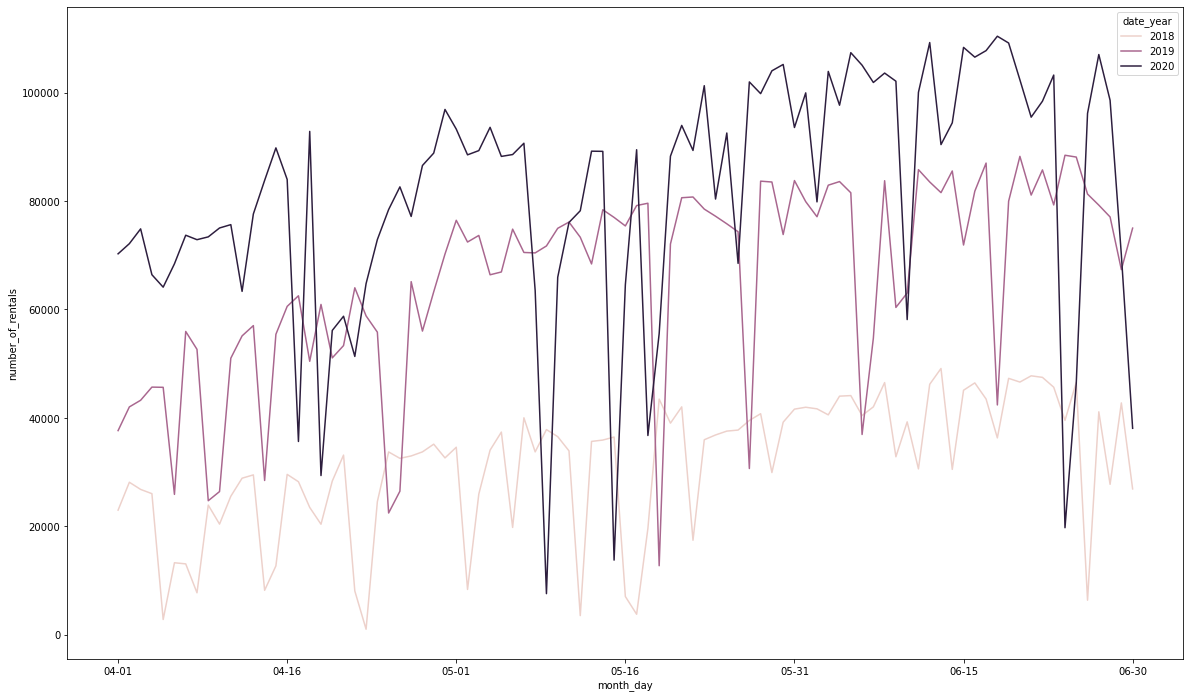

In [9]:
plt.figure(figsize = (20, 12))
sns.lineplot(x = 'month_day', y = 'number_of_rentals', data = train_df, hue = 'date_year')
plt.xticks([0, 15, 30, 45, 60, 75, 90])
plt.show()

전체적인 경향성을 보면 최근으로 올수록 따릉이 사용량이 증가하고 있음을 볼 수 있습니다. 다만 연도와 상관없이, 대여량이 매우 낮은 날에는 큰 차이 없이 바닥을 치고 있음을 알 수 있습니다. 바닥을 치는 값들이 있기 때문에, 증가 추세가 정말 맞는지 통계량으로 다시 한번 확인해보려고 합니다. 중간값을 활용해 보겠습니다.

In [10]:
# 중간값으로 비교한 이유는 평균값으로 비교시 너무 낮게 치는 값들이 영향을 크게 주므로 중간값을 사용한다.
train_df['number_of_rentals'].groupby(train_df.date_year).agg('median')

date_year
2018    33923
2019    72066
2020    88508
Name: number_of_rentals, dtype: int64

변수들간의 상관관계를 확인해보고자 합니다.

### 변수들간의 관계 분석 - 기후적인 요인이 대여량에 영향을 줄 것인가?

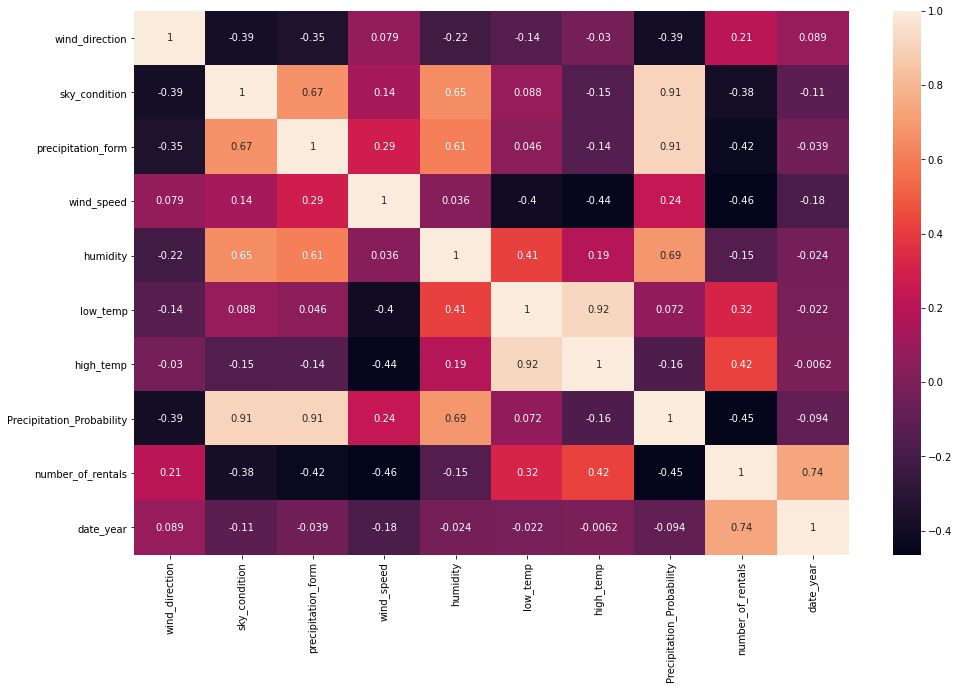

In [11]:
plt.figure(figsize = (16, 10))
sns.heatmap(train_df.corr(), annot = True)
plt.show()

또한 각 변수들간의 관계 파악을 시각적으로 보기 위해, pairplot을 통해 관찰해보겠습니다.
이 때, 연도별로 변화가 있는지 파악을 하기 위해 hue를 year로 두어 연도별 변화를 고려하겠습니다.

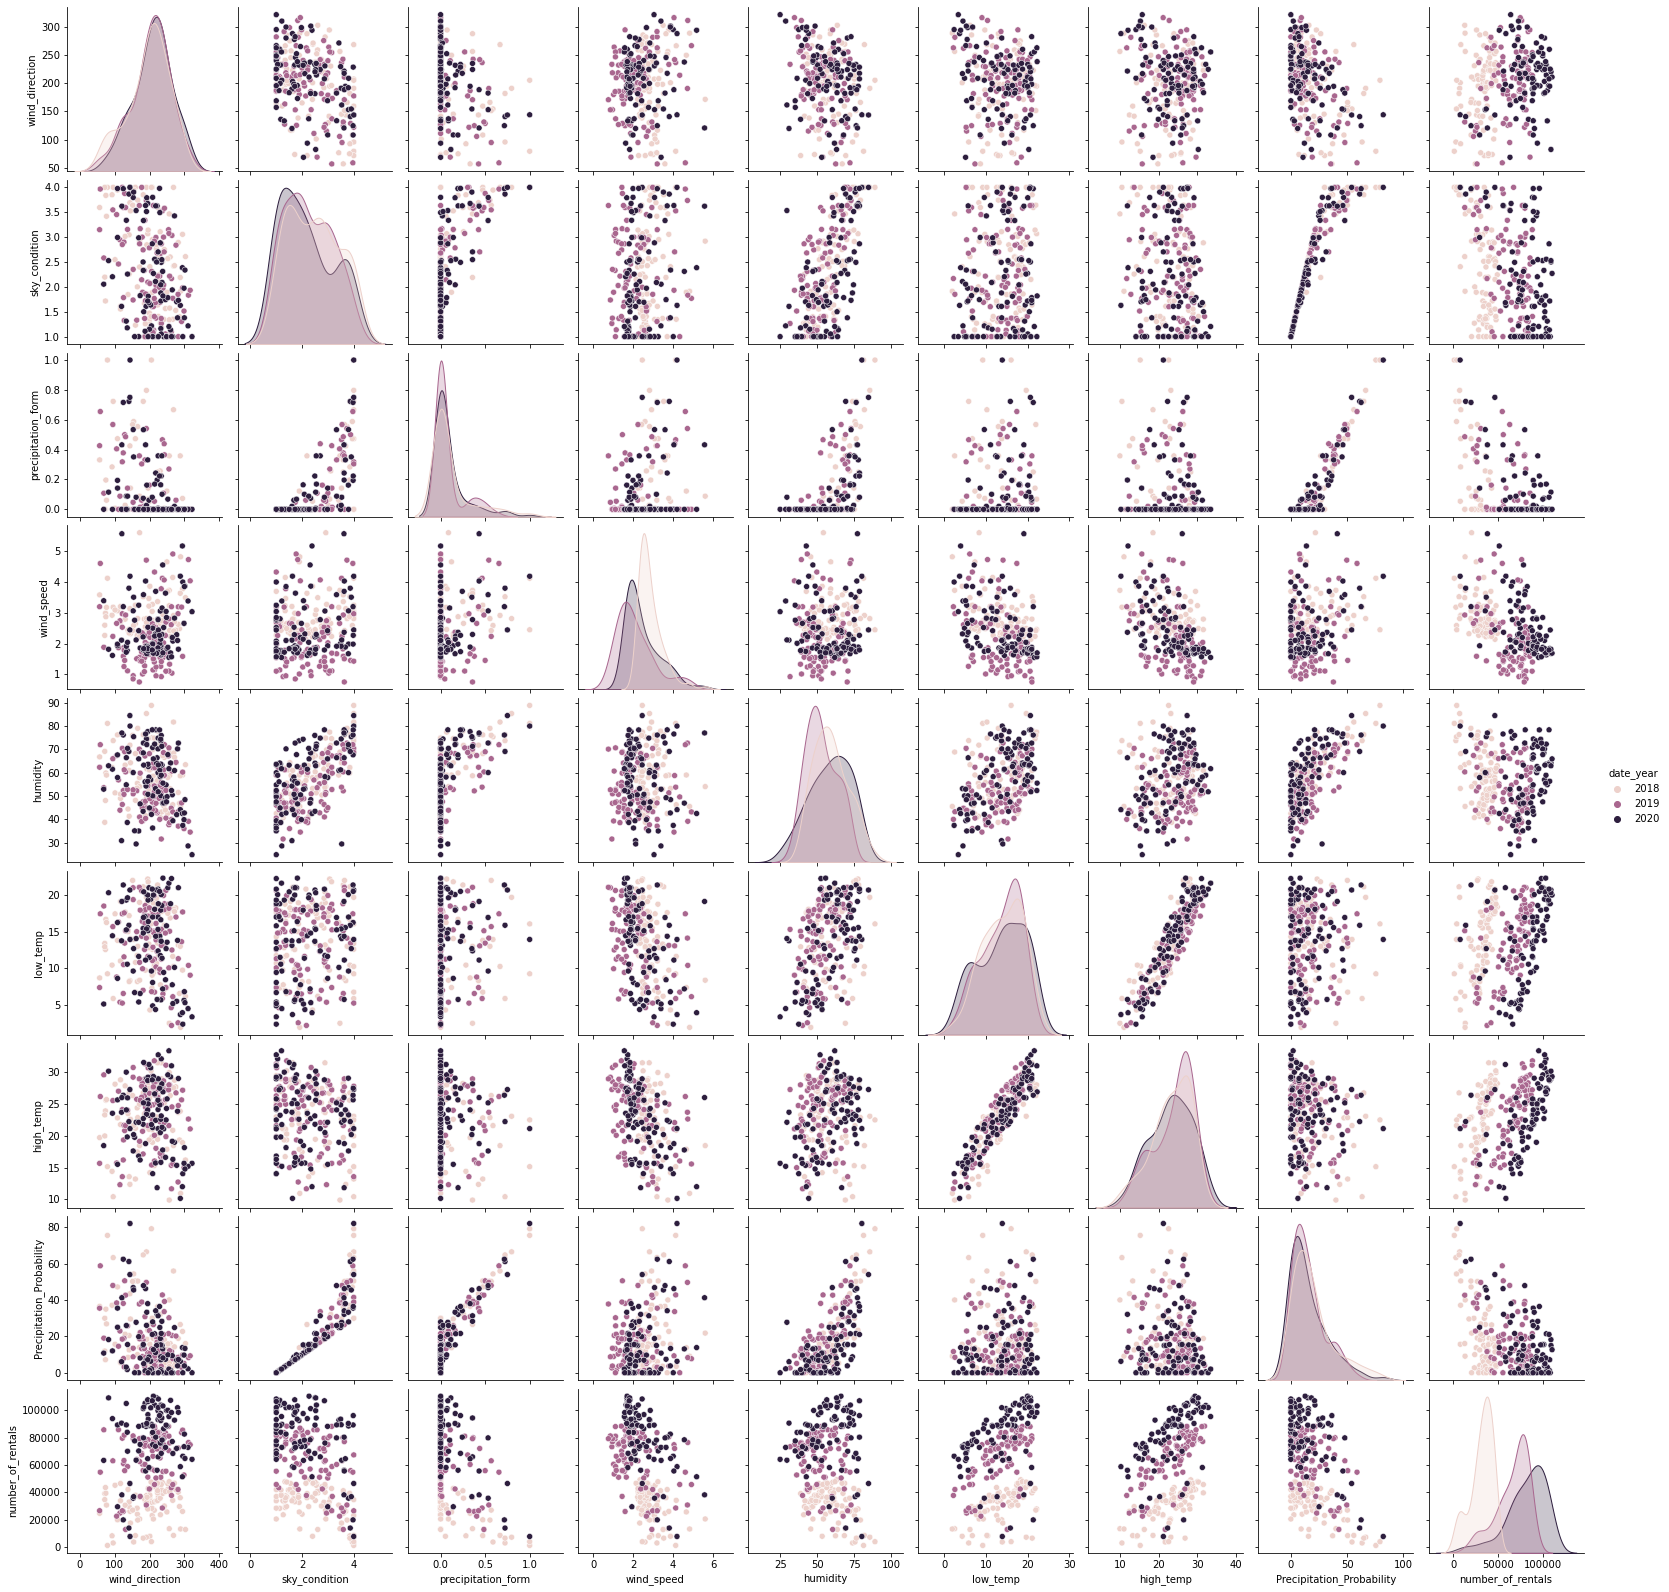

In [12]:
sns.pairplot(train_df, hue = 'date_year')
plt.show()

그래프를 통해 볼 수 있는 부분은 다음과 같습니다.
- 지구온난화나 미세먼지 같은 환경 문제가 존재함에도 불구하고, 생각보다 연도에 따라 기후적인 요소의 차이는 크지 않다.
- 강수량, 바람, 강수확률은 어느정도 강수나 바람이 심하게 불 경우 대여량이 크게 떨어지고 있음을 알 수 있다.
- 바람이 심하게 불거나, 하늘이 매우 어둡거나, 비가 많이 오는 날 등에는 대여량이 크게 떨어지고 있음을 알 수 있다.

따라서 따릉이가 연도별로 사용량이 증가하는 것은 기후적 요인보다는 자체로 사용량이 증가하고 있겠구나 하고 추리해볼 수 있습니다.
별 이변이 없다면, 2020 -> 2021의 상승분은 2019 -> 2020 상승분과 유사하지 않을까 생각할 수 있으며, 사실 가지고 있는 자료로는 이 이상의 추리는 어렵습니다.

### 요일에 대한 분석 - 평일, 주말 사용량이 많이 다를까?

앞에서 언급한 내용을 다시 복기하면, 따릉이는 출퇴근시간에 많이 사용량이 많다는 정보를 기사 등을 통해서 얻었다고 언급했습니다.
이를 바탕으로 분석하면 월-금 / 토-일의 차이를 보는 것이 유의미할 것입니다.
또한 날씨에 따라 바닥을 치는 영향을 없애고자, 중간값을 통해 분석합니다.

In [13]:
def is_weekend(t):
    if t.weekday() >= 5:
        return 1
    else:
        return 0

In [14]:
train_df['is_weekend'] = train_df.date_time.apply(lambda t : is_weekend(t))
test_df['is_weekend'] = test_df.date_time.apply(lambda t : is_weekend(t))

In [15]:
train_df['number_of_rentals'].groupby(train_df.is_weekend).agg('median')

is_weekend
0    60925
1    64330
Name: number_of_rentals, dtype: int64

물론 통계 검증을 통해 정말 유의미한 차이가 있는지 확인해야겠으나, 여기서는 생략하기로 합니다.  
값만 봐서는 주말인 경우에 중간값 자체는 오히려 더 높다는 것을 알 수 있습니다. 따라서 평일/주말 변수는 사용해보기로 합시다.  
(아마 날씨가 맑을 때, 주말에 나들이용으로도 쓰지 않을까? 라고 생각해 볼 수 있을 것입니다.)

## 모델 생성 계획

여러 모델이 있지만, 우선 생각해 볼 수 있는 모델들은 다음과 같습니다.  
- 단순선형회귀
- 앙상블 기법 : 랜덤포레스트 , XGBoost  
데이터 수가 많지 않기에 LightGBM은 후보에서 제외하였습니다.  
여기서는 단순 선형회귀랑 XGBoost에 대해서만 확인해보기로 하겠습니다.  

In [16]:
# 월별 시각화를 하느라 만들었던 불필요 변수 제거.
train_df = train_df.drop('month_day', axis = 1)

### 변수 선택 및 생성

####  기후에 대한 고려(1)

- 다시 corr를 확인해보면, 바람의 방향이 상대적으로 덜 줄요하다고 말하는데, 솔직히 상식적으로도 바람의 방향이 그렇게 중요해보이지는 않다. drop으로 결정한다. 게다가 바람이 0도인게 어느 방향인지를 몰라서 자전거가 더 돌기 좋은 방향을 찾기도 어렵습니다.

- 습도와 기온에 대해서는 그 자체가 춥다, 덥다로도 쓸 수 있지만, 단순히 조금 촉촉하다고 자전거를 안 탈거 같지는 않고 대신 불쾌지수 개념을 사용해보기로 결정했습니다.
  - https://dacon.io/competitions/official/235837/codeshare/3706?page=1&dtype=recent
    - 해당 자료에서 불쾌지수를 사용한 아이디어를 확인하였습니다.
    
- 또한 강우 확률보다는, 강우의 정도를 자체로 나타낸 것이 실제 비가 내린 정도를 나타내기에 좋을 것이기에 강우확률 변수를 제외한다.
  - 강우 확률은 실제로 내린 양을 나타내지 않기에 쓰기는 어려울 것 같습니다.
- 이미 기온의 변수가 달을 설명한다. 굳이 달을 사용할 이유도 없어보입니다.. 이에 따라 시간의 흐름도 굳이 사용할 필요 없어보입니다.

해당 내용들을 차례차례 진행해봅시다.

In [17]:
# 필요없는 행을 지운다. 바람의 방향, 강수 확률, 시간에 대한 데이터를 지워줍니다.
train_df = train_df.drop(['date_time', 'wind_direction', 'Precipitation_Probability'], axis = 1)
test_df = test_df.drop(['date_time', 'wind_direction', 'Precipitation_Probability'], axis = 1)

다음은 불쾌지수를 적용합니다. 그리고 불쾌지수를 적용하면 습도에 대한 데이터는 사용할 이유가 없습니다. 상관관계도 상대적으로 낮게 나오기에 충분히 drop해도 무리가 없을 것입니다.

In [18]:
# 불쾌지수 공식의 활용
def get_discomfort(humid, min_t, max_t):
    # 전체적인 탑승의 경향성을 반영하기 위해 출퇴근 시간의 사용량이 많음에도 불구하고, 평균온도로 고려합니다.
    temp = (min_t + max_t)/2
    humid = humid / 100
    
    discomfort = 1.8 * temp - 0.558 * (1 - humid) * (1.8*temp - 26) + 32
    return discomfort

In [19]:
train_df['discomfort'] = [0] * len(train_df)
for i in range(len(train_df)):
    train_df.discomfort[i] = get_discomfort(train_df.humidity[i], 
                                            train_df.low_temp[i],
                                            train_df.high_temp[i])
    
test_df['discomfort'] = [0] * len(test_df)
for i in range(len(test_df)):
    test_df.discomfort[i] = get_discomfort(test_df.humidity[i], 
                                           test_df.low_temp[i],
                                           test_df.high_temp[i])

<ipython-input-19-92214cbcf69b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.discomfort[i] = get_discomfort(train_df.humidity[i],
<ipython-input-19-92214cbcf69b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.discomfort[i] = get_discomfort(test_df.humidity[i],


또다른 추가 변수를 고려해보려고 합니다.

#### 악조건에 대한 고려 - hardship

기후적인 부분을 조금 더 반영하여 추가 변수를 만들어봅시다.

악조건에 대한 변수를 어떻게 반영할 수 있을지 고민해보겠습니다.
강수량에 대한 부분은 어느 시간대에 어떻게 강수가 되었을지 어렵기에 다른 방식으로 접근해보고자 합니다.
우리가 심리적인 부분으로, 날씨도 흐리고 바람도 많이 부는 날에 자전거를 타고 싶진 않을 겁니다.
날씨가 매우 맑아도, 바람이 심하게 불면 자전거를 타도 되나 싶을거고, 그 반대의 경우도 있을 수 있습니다.
이를 고려하기 위한 변수인 hardship을 도입하겠습니다.

hardship은 풍속에 sky_condition을 곱해서 진행하는 것으로 충분합니다.

sky_condition의 변수를 다시 복습해보면, 맑으면 1, 구름 많으면 3, 흐림은 4입니다. 즉 좋은 날씨가 아닐수록 값이 큽니다.
따라서 풍속에 이를 곱하면 자전거를 타기 얼마나 어려울지를 수치적으로 표현 가능할 것입니다.

In [20]:
train_df['hardship'] = train_df['sky_condition'] * train_df['wind_speed']
test_df['hardship'] = test_df['sky_condition'] * test_df['wind_speed']

#### 기후에 대한 고려 (2)
날씨에 대한 고려를 할 때 단순히 기온적으로 춥다, 덥다만 논하기에는 어려운 부분들이 있습니다.
날씨가 어떻게 더운지 습도에 따른 불쾌함을 반영한 불쾌지수는 고려하였으니 반대로 추운 부분에 대해 고려해볼 수 있을 것입니다.
사실 비가 오거나, 아니면 4월 초반 정도는 꽃샘추위 등을 논할 수 있는 달일겁니다. 따라서 추위에 대한 변수는 고려해야 합니다.

추위를 탈 때, 단순히 기온이 낮은 것 뿐만 아니라 체감추위라는 것에 대한 개념을 뉴스에서 들어보신 적이 있을 겁니다. 이는 풍속에 따라 결정할 수 있습니다.

또한 일교차가 클수록 체감 추위는 더 클 것입니다. 이에 따라 일교차와, 추운 정도를 반영하기 위한 지표를 만들겠습니다.
여기서 추위를 고려할때는 최저온도를 기준으로 하겠습니다. "추위"에 대한 고려이기 때문입니다.

In [21]:
# 추운 정도 반영
train_df['cold_measure'] = train_df['low_temp'] / train_df['wind_speed']
test_df['cold_measure'] = test_df['low_temp'] / test_df['wind_speed']

# 일교차 반영
# 일교차를 반영하면, 체감온도를 반영할 수 있다.
train_df['temp_diff'] = train_df['high_temp'] - train_df['low_temp'] 
test_df['temp_diff'] = test_df['high_temp'] - test_df['low_temp']

추운 정도의 지표에서 주어진 baseline EDA에서는 곱하기를 사용한 것으로 아는데, 저는 여기서 나눗셈을 활용했습니다.
이렇게 한 이유는, 온도가 낮은데, 바람이 더 불면 더 추울 것이기 때문에 분수로 나눠주어, 저 값이 더 낮을수록 더 춥겠다라는 지표로 음의 방향의 관계를 가질 변수를 만들어 주었습니다.

아, 그리고 마지막으로 습도에 대한 정보와 불쾌지수가 겹치므로 습도를 drop하겠습니다.

In [22]:
train_df = train_df.drop('humidity', axis = 1)
test_df = test_df.drop('humidity', axis = 1)

지금까지 만든 데이터를 점검해봅시다.!

In [23]:
train_df

,sky_condition,precipitation_form,wind_speed,low_temp,high_temp,number_of_rentals,date_year,is_weekend,discomfort,hardship,cold_measure,temp_diff
0,4.000,0.000,3.050,12.600,21.000,22994,2018,1,61,12.200000,4.131148,8.400
1,2.950,0.000,3.278,12.812,19.000,28139,2018,0,60,9.670100,3.908481,6.188
2,2.911,0.000,2.690,10.312,15.316,26817,2018,0,55,7.830590,3.833457,5.004
3,3.692,0.425,3.138,8.312,12.368,26034,2018,0,51,11.585496,2.648821,4.056
4,4.000,0.723,3.186,5.875,10.421,2833,2018,0,48,12.744000,1.844005,4.546
...,...,...,...,...,...,...,...,...,...,...,...,...
268,3.980,0.223,2.271,20.500,27.526,96150,2020,0,73,9.038580,9.026860,7.026
269,2.865,0.081,1.794,20.812,28.842,107001,2020,1,74,5.139810,11.600892,8.030
270,1.730,0.000,1.820,21.000,29.053,98568,2020,1,74,3.148600,11.538462,8.053
271,2.257,0.088,2.043,19.625,26.000,70053,2020,0,70,4.611051,9.605972,6.375


In [24]:
test_df

,sky_condition,precipitation_form,wind_speed,low_temp,high_temp,date_year,is_weekend,discomfort,hardship,cold_measure,temp_diff
0,3.000,0.000,2.900,11.800,20.667,2021,0,59,8.700000,4.068966,8.867
1,3.850,0.000,2.662,12.000,19.000,2021,0,59,10.248700,4.507889,7.000
2,4.000,0.565,2.165,8.875,16.368,2021,1,55,8.660000,4.099307,7.493
3,3.466,0.466,3.747,6.250,17.368,2021,1,54,12.987102,1.668001,11.118
4,1.500,0.000,1.560,7.188,18.684,2021,0,56,2.340000,4.607692,11.496
...,...,...,...,...,...,...,...,...,...,...,...
86,3.980,0.223,1.066,20.312,28.579,2021,1,73,4.242680,19.054409,8.267
87,2.777,0.135,1.290,20.812,29.000,2021,1,73,3.582330,16.133333,8.188
88,3.338,1.270,1.692,21.000,28.789,2021,0,73,5.647896,12.411348,7.789
89,3.270,0.595,1.470,21.000,29.421,2021,0,74,4.806900,14.285714,8.421


이제 이를 바탕으로 모델을 직접 학습시켜 봅시다.

## 모델 학습 과정

모델 학습 계획에서 세운 두가지 지표에 대해서만 확인해보려고 합니다.

### 사전 준비 - 정답지 만들기, 평가 지표 생성

In [25]:
# 정답 제출 파일 만드는 함수
def get_result(pred):
    sample_submission['number_of_rentals'] = pred
    sample_submission.to_csv('result.csv', index = False, encoding = 'UTF-8')

In [26]:
# 평가지표, 이 대회에서는 NMAE를 사용하게 됩니다.
def get_nmae(pred, y):
    nmae = np.mean(abs(pred-y)/y)
    return nmae

### train test 분리?
train, test를 분리하고자 하니 다음과 같은 문제가 존재합니다.
- 각 일자별로 어떤 기후 특성을 가지고 있는지 알기 어려움
- 그래도 일자가 흐름에 따른 어느정도의 대여량 증가 추세가 보임

분리를 했을 때, 학습이 정말 유의미한지 알기가 어렵고 test에서도 동일한 기간에 대해 예측해야 합니다.

검증을 통해 모델을 선택하는 것이 좋은 선택이겠으나, 저는 여러번의 trial and error가 차라리 낫겠다는 판단에, 이번 데이터 분석에서는 train 과 test를 분리하지 않겠습니다. X, y만 분리하겠습니다.

### Linear Regression 학습_시도
물론, 표준화를 거쳐야 겠지만 위에서 시각화를 본 그래프를 떠올리면 왠지, 선형회귀가 잘 안될거 같다는 느낌적 예감이 듭니다.
약식적으로 간단하게만 확인해봅시다.

In [27]:
X = train_df.drop('number_of_rentals', axis = 1)
y = train_df['number_of_rentals']

In [28]:
reg = LinearRegression()
reg.fit(X, y)

# X를 다시 학습시켜 훈련 데이터 전체의 예측 정도는 확인해보자.
X_pred = reg.predict(X)
get_nmae(X_pred, y)

0.30812151147228606

단순 선형회귀를 사용했을 경우, 오차율이 30% 정도로 상당히 영 좋지 않은(?) 결과가 나옴을 알 수 있습니다.
2021년도에 대한 데이터는 훈련 데이터에 아예 없기에 이대로 제출하기에는 좋지 않아 보입니다.

#### 왜 이런 문제가 발생한 걸까?


복잡하게는 회귀진단을 활용하여 데이터들에 대해 진단해보고 영향력이 크면서 outlier인 데이터를 제외하여 선형회귀를 하는 법이 있겠습니다만, 그렇게 하기엔 날씨가 bad하여 대여량이 매우 낮은 값들을 다 쳐낼거만 같은 예감이 듭니다. 이런식의 접근은 좋아 보이지 않습니다.

여기서는 간단하게 statmodels의 summary를 통해 무슨 일이 일어났는지만 확인해보고 넘어갑시다.

In [29]:
# stat_models는 상수항 추가를 꼭 이렇게 처리해줘야합니다.
X0 = sm.add_constant(X)
model = sm.OLS(y, X0)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      number_of_rentals   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     153.2
Date:                Sun, 14 Nov 2021   Prob (F-statistic):          2.48e-103
Time:                        13:17:06   Log-Likelihood:                -2916.4
No. Observations:                 273   AIC:                             5855.
Df Residuals:                     262   BIC:                             5895.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -4.834e+07   1.73

다중 공산성 문제는 만든 여러 변수들이 기존의 다른 변수들과 관계가 있기 때문에 발생했다고 치고 넘어가봅시다.
주목해야 할 부분은 t값과 관련된 부분들입니다. P>|t|를 통해서는 회귀계수의 유의성을 확인할 수 있습니다.
유의수준 0.05% 에서 너무 많은 변수가 유의미하지 않음 또한 확인할 수 있습니다.

그러나, 특히 온도를 통해 간접적으로 시기를 얻어낼 수 있고, 또한 더위와 습도를 혼합한 더움에 대한 추가 지표는 discomfort외엔 없습니다. 유의하지 않다고 무작정 버리기엔 유실되는 정보가 너무 많을 것입니다.
따라서, 선형회귀는 쓰기 어려울 것 같습니다.

### XGBoost의 적용

따라서 여기서는 앙상블 모델을 적용하고자 합니다. 특히 트리모델을 활용하는 이유는 특정 기준으로 날씨가 매우 나쁘거나 하면 선제적으로 쳐내어 낮은 값을 할당해주겠다는 기대를 할 수 있어, 트리모델 쪽 앙상블 기법을 적용하겠습니다.

In [30]:
reg = XGBRegressor(max_depth = 4, n_estimators = 100)
reg.fit(X, y)
pred = reg.predict(test_df)

# X값을 토대로 다시 정확도 확인
X_pred = reg.predict(X)
get_nmae(X_pred, y)

0.005514551818855783

정확도가 매우 좋아졌음을 알 수 있습니다. 확실히 분류 기준을 통해 특정 값들을 부여하는 방식이 훨씬 좋겠음을 예측할 수 있습니다.

In [31]:
# get_result(pred)

실제로 해당 코드를 실행하여 값을 제출해보면 test 기준 NMAE 0.3945 를 얻어내었습니다. 
하지만 여기서 더 향상시킬수는 없을까요? 다양한 시도를 고려해 볼 수 있습니다.

## 모델 성능 향상 + 연도는 정말 고려할 수 없는 것일까?

### CV
물론, 앞에서 train, test를 나누지 않겠다고 논한 상황에서 CV를 논하는건 웃기지만, 최적의 Parameter를 찾기 위해 CV를 시도해 볼 수 있습니다. 깊이를 어디까지, estimator를 어디까지 쓸지에 대해서 결정해봅시다.

In [32]:
reg_cv = XGBRegressor()
xgb_params = {'max_depth' : [4, 5, 6, 7],
              'n_estimators' : [5, 10, 20, 50, 100, 200],
              'random_state' : [42]}
grid = GridSearchCV(estimator = reg_cv, param_grid = xgb_params, scoring = 'neg_mean_absolute_error')

grid.fit(X, y)
best_param = grid.best_params_
print(best_param)

{'max_depth': 4, 'n_estimators': 50, 'random_state': 42}


estimator 50, max_depth 4일때 최적의 성능을 보인다 말하고 있습니다.
여기서 저는 estimator 개수는 100으로 다시 유지했는데, 그 이유는 전체 데이터를 학습하여 아예 새로운 연도를 학습해줘야 하기에 estimator은 100으로 유지시켜 충분히 학습기를 준비시키는 것이 더 좋겠다고 판단하여 max_depth = 4만 그대로 따르기로 결정했습니다.

### XGBoost는 어떤 결정을 내리고 있던 것일까?
트리의 시각화를 통해 XGBoost가 어떤 결정을 내리고 있는지를 확인해 볼 수 있습니다.

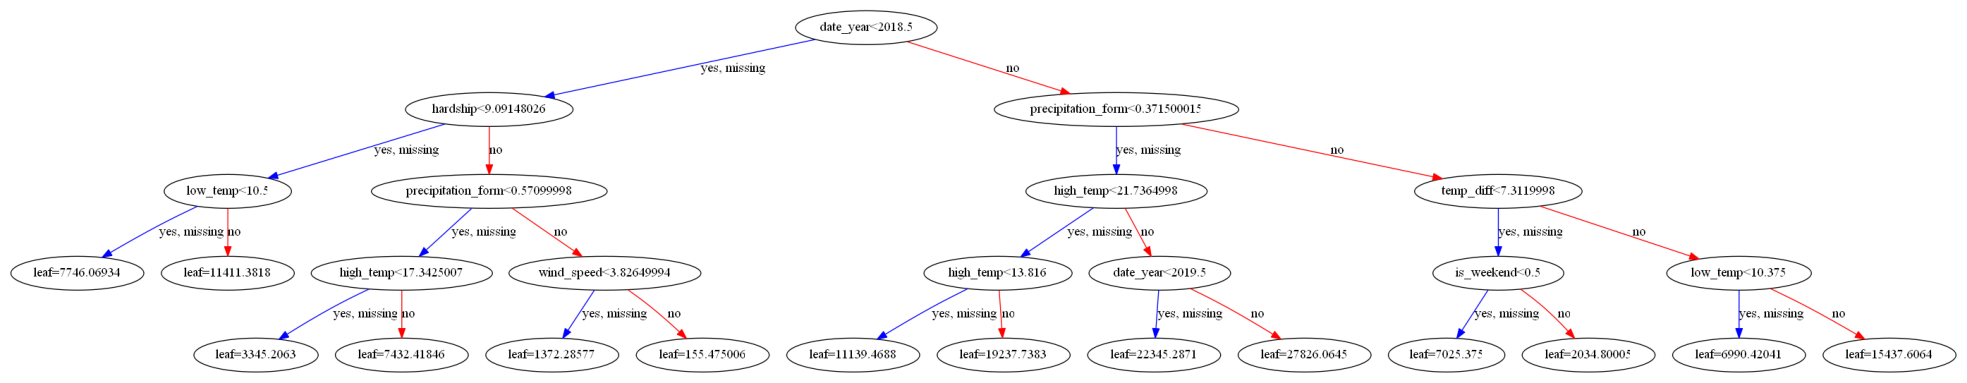

In [33]:
plot_tree(reg)
fig = plt.gcf()
fig.set_size_inches(35, 25)

잘 살펴보면, 최상단에서 연도로 한번 2018년과 2019년/2020년을 분리한 이후, 이후로는 우측에서 말단에서 한번 date_year를 사용한 것 빼고는 year를 생각보다는 많이 쓰고 있지 않습니다. 기후의 정보 우주로 분류를 하는것으로 보이며, 혹은 연도가 가장 1차적인 분류 기준으로 쓰이는 것을 고려한다면 2021년의 데이터는 2020년과는 차등을 둬야 할 것입니다.

변수별 중요도를 다시 한번 확인하기 위해 plot_importance를 해봅시다.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

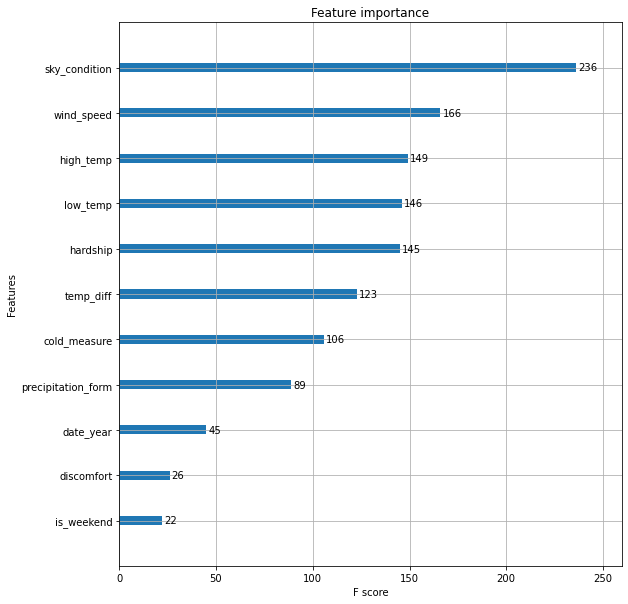

In [34]:
fig, ax = plt.subplots(figsize=(9,10))
plot_importance(reg, ax=ax)

importance를 고려했을 때 불쾌지수나 주말 여부도 문제지만 어찌보면 상승분을 반영해줘야할 '연도'에 대한 부분이 학습에 잘 반영이 되고 있지 않음을 알 수 있습니다.

### 연도별 상승분 반영 및 최종 모델 정리

연도별 상승분을 반응하려고 한다. 이를 위해 2018년 데이터, 2019년 데이터, 2020년 데이터의 대여량 합산의 비율 차이를 보자.

In [35]:
reg_2018 = sum(train_df.loc[train_df['date_year'] == 2018, 'number_of_rentals'].values)
reg_2019 = sum(train_df.loc[train_df['date_year'] == 2019, 'number_of_rentals'].values)
reg_2020 = sum(train_df.loc[train_df['date_year'] == 2020, 'number_of_rentals'].values)
print(reg_2019/reg_2018)
print(reg_2020/reg_2019)

2.095622727544442
1.2358394161314505


2018년에서 2019년으로 갈때, 동기간 따릉이 이용량은 약 2배,  2019년에서 2020년은 1.2배 증가했음을 알 수 있다.
이 상승분 추세를 반영하는 것이 필수적일 것이다. (다시 강조하지만 2021년도 상승분은 xgboost가 학습시켜줄 수 없다!)
상승분의 값을 예측하기는 어려우므로, 2019년~20년도의 상승분인 1.2배를 동일하게 적용하는 것이 최선일 것이다.

In [36]:
# 최종 모델이다. 예측된 값에 일괄적으로 1.2배를 곱해서 상승분 반영으로 마무리한다.
reg = XGBRegressor(max_depth = 4, n_estimators = 100)
reg.fit(X, y)
pred = 1.2 * reg.predict(test_df)
# get_result(pred)

이대로 학습할 경우, public 0.32476 정도를 얻게 된다. 
- public : 23위 (0.32476)
- private : 1위 ! (0.25052)

## Additional. 회귀진단

분석 과정과는 별개로 선형회귀가 왜 실패하는지를 조금 더 자세히 확인하고자 회귀진단을 다양한 요소로 시도해보려고 합니다.

여기서는 2021년도의 예측 이전에, 앞에서 2018~2020년도의 훈련 데이터에 대해서도 학습이 잘 이뤄지지 않았기 때문에, 굳이 test data에 대해서는 고려하지 않겠습니다.

우선 선형회귀를 다시 실시하겠습니다. 뒷 내용을 위해 sm.OLS를 활용합니다.

In [51]:
X0 = sm.add_constant(X)
model = sm.OLS(y, X0)
result = model.fit()
pred = result.predict(X0)

실제 훈련 데이터에서 어떻게 학습되었는지를 확인하고자, 예측한 모델을 바탕으로 다시 X를 대입해보았습니다.

다음 사항들을 확인해보겠습니다.
- 모델의 선형성은 잘 만족되고 있었는가?
- 잔차에 대한 기본 가정은 만족하는가? (정규성, 등분산성, 독립성)
- 다중공산성 문제는 없는가? 있다면 어떻게 제거해야 하는가?

### 회귀분석의 기본 가정 검증

#### 모델의 선형성 검증

예측값과 잔차의 차이를 보려고 한다. 잔차의 추세가 영 좋지 않아 예측값과의 차이가 매우 크다면, 선형성이 잘 만족되고 있지 않다는 의미일 것이다.

C:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


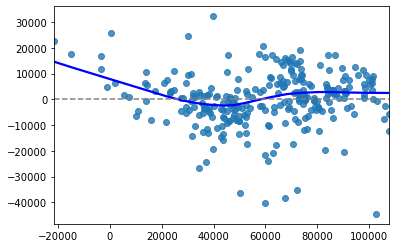

In [55]:
residual = y - pred
sns.regplot(pred, residual, lowess = True, line_kws = {'color': 'blue'})
plt.plot([pred.min(), pred.max()], [0, 0], '--', color = 'grey')
plt.show()

잔차의 분포를 살펴보면, 어느정도는 회색 실선, 즉 추세를 빠라가는 느낌을 주지만 그럼에도 불구하고 잔차가 굉장히 크게 나는 점들을 확인해 볼 수 있다. 실제 값보다 pred값이 더 크게 나온 값들이므로, 날씨가 좋지 않은 상황들에, 즉 바닥을 치는 값들의 예측에 실패하지 않았을까를 추론해 볼 수 있다.

#### 잔차의 정규성 검증

잔차의 전규성 검증은 통계적 방법론을 통해서도 진행 가능할 것이다.
정규성 검증의 많은 방법들이 있다. 여기서는 우선 시각적 확인 방법인 Q-Q Plot을 활용해보도록 한다.

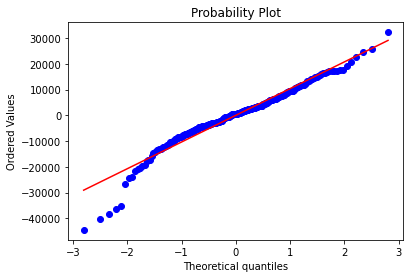

In [53]:
stats.probplot(residual, plot = plt)
plt.show()

이 그래프는 잔차들을 낮은 값부터 차레대로 나열하여 정규성을 띄는지 검증하는 그래프이다. 정규성을 만족할수록 잔차들은 빨간 선에 모이게 된다. 그러나 역시, 잔차가 음의 값을 띈 부분에서 정규성을 만족하지 않는 것으로 보인다. 전체적인 추세도 이런지 통계적 검증을 해보자. 가장 대표적인 샤피로 검정을 활용한다.

In [54]:
stats.shapiro(residual)

ShapiroResult(statistic=0.9526735544204712, pvalue=9.718631588384596e-08)

p-value값이 매우 작다. 유의수준 1% 정도에서도 귀무가설이 기각된다. **샤피로 검정에서의 귀무가설 기각은 잔차의 정규성을 만족하지 않는다는 의미** 이다.!

#### 잔차의 등분산성 확인

예측값에 따라, 잔차가 어떻게 달라지는지를 확인해 볼 수 있다.
등분산성을 학인하기 위해, regplot을 다시 그려보자.

C:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

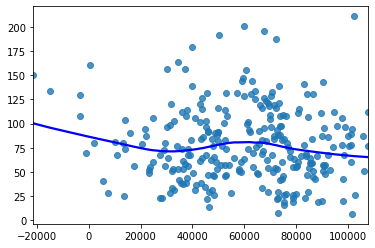

In [57]:
sns.regplot(pred, np.sqrt(np.abs(residual)), lowess = True, line_kws = {'color': 'blue'})

등분산성의 의미는, 파란색 선이 수평선에 가까울수록, 분산이 동일하게 유지될것을 나타낸다. 역시 pred값이 작을 수록 문제가 일어나고 있다.

#### 잔차의 독립성 확인
잔차의 독립성 검정은 Durbin-Watson 값을 통해 볼 수 있다.
이는, statmodels OLS summary에 나와있다.

In [58]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      number_of_rentals   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     153.2
Date:                Sun, 14 Nov 2021   Prob (F-statistic):          2.48e-103
Time:                        13:57:01   Log-Likelihood:                -2916.4
No. Observations:                 273   AIC:                             5855.
Df Residuals:                     262   BIC:                             5895.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -4.834e+07   1.73e+06    -27.875      0.000   -5.18e+07   -4.49e+07
sky_condition       2999.9943   2366.580      1.268      0.206   -1659.943    7659.932
precipitation_form -3.568e+04   4919.535     -7.253      0.000   -4.54e+04    -2.6e+04
wind_speed          2901.4154   2481.878      1.169      0.243   -1985.551    7788.382
low_temp             870.1221    748.064      1.163      0.246    -602.861    2343.105
high_temp           1464.5967    685.278      2.137      0.034     115.242    2813.951
date_year           2.396e+04    862.968     27.768      0.000    2.23e+04    2.57e+04
is_weekend         -1583.7664   1474.539     -1.074      0.284   -4487.221    1319.689
discomfort          -586.3170    985.433     -0.595      0.552   -2526.694    1354.060
hardship           -1819.3935    886.977     -2.051      0.041   -3565.905     -72.882
cold_measure         719.9213    363.877      1.978      0.049       3.426    1436.416
temp_diff            594.4745    277.390      2.143      0.033      48.277    1140.672
==============================================================================
Omnibus:                       44.907   Durbin-Watson:                   1.636
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.216
Skew:                          -0.783   Prob(JB):                     8.62e-24
Kurtosis:                       5.624   Cond. No.                     1.82e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.36e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

DW 값이 1.5~2.5 사이일 경우 잔차의 독립성이 잘 확보되었다고 말할 수 있다고 합니다.  1.636 정도이므로 잔차의 독립성에 대해서는 걱정하지 않아도 될 듯 합니다.

### 예측 값의 유효성

그런데 위를 보면 이상한 점이 한가지 있습니다. 선형 모델의 특성이어서인지, 음수 예측값을 뱉어버리는 경우가 존재합니다.!
이런 예측은 전혀 유효하지 않습니다.

### 다중공산성 고려

또한 앞에서 한번 언급했지만 summary 위의 예시를 보면, strong multicollinearity problems이 우려된다는 언급이 있습니다. 이를 해결해보려고 합니다.

#### VIF 고려
다중공산성 문제를 체크하기 위해 VIF를 활용합니다. 

In [60]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,78.321439,sky_condition
1,2.920769,precipitation_form
2,97.878479,wind_speed
3,inf,low_temp
4,inf,high_temp
5,3070.514079,date_year
6,1.460518,is_weekend
7,8687.492103,discomfort
8,84.710377,hardship
9,18.523340,cold_measure


VIF가 inf인 값이 무려 3개나 있다. 이들 중 회귀계수가 유의미하지 않은 변수는 'low_temp'이다.
또한 discomfort나 wind_speed, sky_condition 역시 회귀계수도 유의미하지 않으며 VIF값 또한 매우 높다.(보통 10 이상은 위험하다고 판단)
이들 변수는 drop한다.

In [73]:
X_drop = X.drop(['low_temp', 'discomfort', 'wind_speed', 'sky_condition'], axis = 1)
X0_drop = sm.add_constant(X_drop)
model = sm.OLS(y, X0_drop)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      number_of_rentals   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     219.7
Date:                Sun, 14 Nov 2021   Prob (F-statistic):          1.99e-106
Time:                        14:14:23   Log-Likelihood:                -2917.3
No. Observations:                 273   AIC:                             5851.
Df Residuals:                     265   BIC:                             5880.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -4.783e+07   1.66e+06    -28.818      0.000   -5.11e+07   -4.46e+07
precipitation_form -3.666e+04   4739.728     -7.734      0.000    -4.6e+04   -2.73e+04
high_temp           1490.1394    207.608      7.178      0.000    1081.368    1898.911
date_year            2.37e+04    821.823     28.843      0.000    2.21e+04    2.53e+04
is_weekend         -1356.9045   1446.185     -0.938      0.349   -4204.380    1490.571
hardship            -749.6700    319.838     -2.344      0.020   -1379.417    -119.923
cold_measure         688.9111    297.072      2.319      0.021     103.990    1273.833
temp_diff            108.8081    421.362      0.258      0.796    -720.835     938.451
==============================================================================
Omnibus:                       43.679   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.674
Skew:                          -0.764   Prob(JB):                     5.07e-23
Kurtosis:                       5.587   Cond. No.                     5.15e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.15e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [74]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_drop.values, i) for i in range(X_drop.shape[1])]
vif["features"] = X_drop.columns
vif

,VIF Factor,features
0,2.708544,precipitation_form
1,57.215996,high_temp
2,68.215078,date_year
3,1.413148,is_weekend
4,11.109329,hardship
5,12.371664,cold_measure
6,40.322142,temp_diff


여전히 몇 개의 변수를 제거했음에도 불구하고, 여전히 다중공산성 문제가 발생하고 있으나 최초의 모델에서 어느정도 유의성을 보여준 변수들이므로 더 버리기는 어려울 것이다.

### 이상치 확인하기

레버리지랑 아웃라이어를 확인하여, 선형회귀에 악영향(?)을 미치는 데이터들이 무엇인지 확인해보고, 이들의 공통점을 어느정도 분석해보는 것이 중요할 것이다. 이를 위해, plot_leverage_resid2를 활용한다. 이 경우, 잔차와 레버리지를 동시에 보는 그래프를 그릴 수 있다.
잔차가 크다는 것은 outlier일 것이며, 레버리지는 y값 영향을 크게 주는 값이기에 두개를 동시에 보는 것은 중요하다.

<Figure size 1152x864 with 0 Axes>

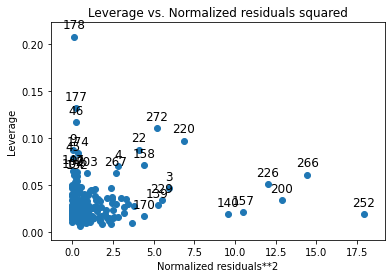

In [88]:
plt.figure(figsize = (16, 12))
sm.graphics.plot_leverage_resid2(result)
plt.show()

표현된 index들이 레버리지도 크고, outlier도 크다.
전부 다 추출은 어렵지만 병백하게 커보이는 몇몇 점들에 대해서 공통점을 찾아보려 한다.

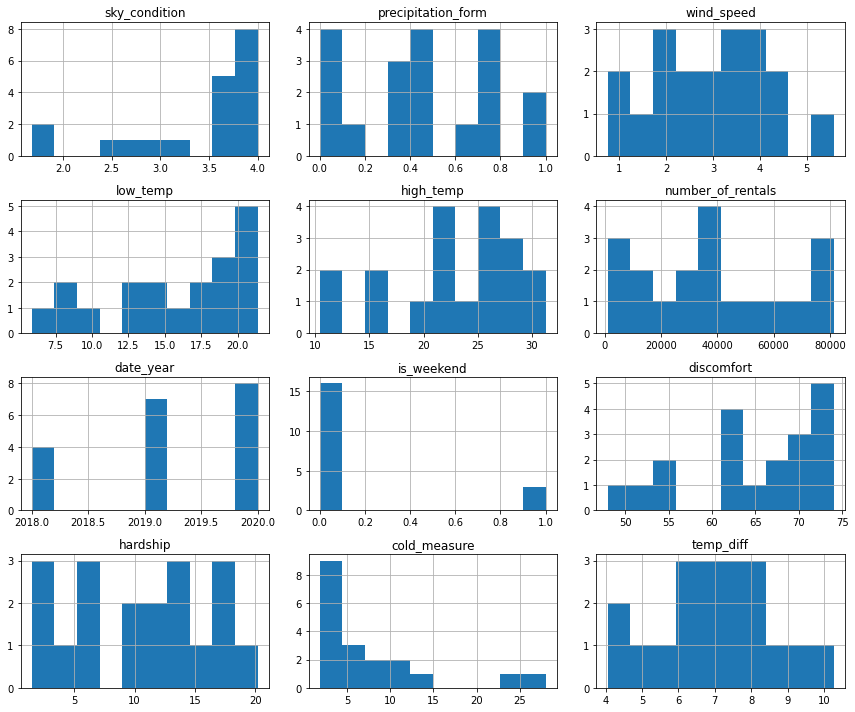

In [94]:
idx = [44, 177, 178, 4, 267, 158, 22, 272, 220, 3, 229, 139, 170, 140, 157, 226, 266, 200, 252]
outs = train_df.loc[idx]
outs.hist(figsize = (12, 10))
plt.tight_layout()
plt.show()

### 그러므로?

이상치를 제외해도 될지에 대해서 데이터를 조금 더 뜯어보자.
그 예시로 2020년도에 예측량이 바닥을 치는 값들을 조사해보면 된다..

In [82]:
train_df.loc[train_df['date_year']==2018].sort_values('number_of_rentals').head(10)

,sky_condition,precipitation_form,wind_speed,low_temp,high_temp,number_of_rentals,date_year,is_weekend,discomfort,hardship,cold_measure,temp_diff
22,4.000,1.000,4.127,9.250,15.158,1037,2018,0,54,16.508000,2.241338,5.908
4,4.000,0.723,3.186,5.875,10.421,2833,2018,0,48,12.744000,1.844005,4.546
41,3.946,0.588,2.590,13.938,21.632,3551,2018,1,63,10.220140,5.381467,7.694
46,4.000,1.000,2.451,16.062,22.526,3802,2018,0,66,9.804000,6.553244,6.464
86,3.851,0.723,3.526,21.125,26.789,6391,2018,0,72,13.578626,5.991208,5.664
45,4.000,0.797,2.815,19.688,23.105,7072,2018,0,69,11.260000,6.993961,3.417
7,2.405,0.054,3.865,4.312,14.211,7758,2018,1,51,9.295325,1.115653,9.899
21,3.851,0.284,2.924,10.438,14.421,8095,2018,1,55,11.260324,3.569767,3.983
13,4.000,0.473,3.251,6.750,13.211,8216,2018,1,51,13.004000,2.076284,6.461
31,4.000,0.667,2.917,10.250,18.474,8374,2018,0,57,11.668000,3.513884,8.224


2020년도에 예측량 하위 10일의 케이스에 대해 살펴보면 
- 날씨가 매우 나쁘거나(precipitation form 1에 매우 가까움)
- 불쾌지수가 70 이상으로 매우 심하던가
- 온도가 매우 낮던가(index 7인 라인 확인, 비도 거의 안오나 바람이 좀 심하게 불고 최하온도가 4도로 매우 낮다..)

이렇게 날씨가 매우 나쁠때는 자전거를 안 탄다는 것을 확인해 볼 수 있다.
문제는 2021년도에도 이런 데이터, 날씨가 좋지 않은 날은 반드시 섞여있을 것이기 때문에 이들을 무작정 날려서 예측하기에도 좋지는 않다.
날씨가 나쁘면 거의 높은 확률로 바닥을 칠 것이다...

## 맺음말

우선 이 이외에도 매우 다양한 시도를 실시해보았습니다. 몇가지 나열하면 다음과 같습니다.
- 2개년 데이터만 활용하여 (2018과2019, 2018과2020, 2019와 2020) 3개의 모델을 별도로 학습 후 평균을 내본다.
- estm을 늘려서 학습량을 늘려서 테스트
- 온도의 기준을 평균온도가 아닌 최저온도나 최고온도 등 다양한 기준으로 변화
- 제공된 EDA에 있는 hot_measure(최고온도 * 습도)를 반영하는 방법

다양한 방법으로 제가 했던 내용을 더 발전시켜 좋은 결과를 얻을 수 있을 것 같습니다. 몇가지 제안하면 다음과 같습니다.
- 날씨가 나쁜 상황을 labeling합니다. labeling된 데이터에 대해서는 연도별 상승분인 1.2배를 하지 않고 학습합니다.
- 상승분에 대해서 조금 더 월별/시기별 등을 반영하여 세분화할 수 있을 것입니다.
- 저는 될거 같지는 않아서 적용하진 않았는데 시계열 모델을 응용하여 적용할 방법이 있지 않을까 고민해 볼 수 있을듯 합니다.
- train/test를 효율적으로 나누는 방법을 찾아, 모델을 더 잘 검증해보는 방법을 사용할 수 있을것입니다.

놓쳤던 부분들은 다음과 같습니다.
- 온도의 분석에 있어, 전날과의 차이를 반영했다면 더 좋지 않았을까?
- 애초에 연도별로 그래프를 그려놓고, 심하게 쳐지는 부분에 대해서 검색을 조금 더 했다면 기후의 문제라는 것에 조금 더 확신을 먼저 가지고 분석했을 것이다.

처음으로 경험해본 대회라서, 이런 저런 다양한 시도를 무지성으로 많이 하기도 했습니다. 그러면서 무엇이 문제일지 계속 파악해보고 훈련 데이터와 평가 데이터의 괴리를 직접 제출을 여러번 하면서 체험하며 배우며 어떻게 극복할지를 많이 고민했습니다. 이번 대회의 경험과 많은 분들의 피드백을 바탕으로 더 성장하여, 더 많은 대회에서 도전하고 데이터를 자유롭게 탐험하고 싶습니다.

좋은 피드백, 질문은 언제나 환영입니다. 감사합니다.!